In [1]:
import pandas as pd
pd.options.display.max_rows = 500
pd.options.display.max_columns = 10
import numpy as np 
# pd.set_option('display.max_colwidth', None)
import os
import re
import ast
import scipy as sp

In [2]:
df = pd.read_csv('/Users/parthmalik/Desktop/GITHUB/Recipe_recsys/recipe_ingredients_dataset/full_df.csv')
ingredients_df = pd.read_csv('/Users/parthmalik/Desktop/GITHUB/Recipe_recsys/recipe_ingredients_dataset/ingredient_df.csv')
df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

In [ ]:
df.info()

In [ ]:
print(df.head(2))

# **MEMORY OPTIMIZATION AS OUR BINARY DF USES A LOT OF MEMMORY**

In [3]:
print(ingredients_df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49718 entries, 0 to 49717
Columns: 7139 entries, id to nakano seasoned rice vinegar
dtypes: int64(7138), object(1)
memory usage: 2.6 GB
None


In [4]:
# converting to int8 to save memory
for column in ingredients_df.columns[2:]: 
    ingredients_df[column] = ingredients_df[column].astype('int8')

print(ingredients_df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49718 entries, 0 to 49717
Columns: 7139 entries, id to nakano seasoned rice vinegar
dtypes: int64(1), int8(7137), object(1)
memory usage: 341.8 MB
None


In [ ]:
# from scipy import sparse
# # using Index 2 for cols as first 2 cols at index 0 and 1 are 'id' and 'cuisine' respectively
# # Convert the DataFrame to a Sparse Matrix, where rows are recipes and columns are ingredients
# sparse_matrix = sparse.csr_matrix(ingredients_df.iloc[:, 2:].values)

In [ ]:
# sparse.save_npz('sparse_ingredients_matrix.npz', sparse_matrix)

# **PCA**

For our case, given that:

The data is binary and sparse.

All features are on the same [0, 1] scale.

We aim to maintain sparsity for computational efficiency.

We might opt to skip standardization or use StandardScaler(with_mean=False).

If you decide that normalizing variances is necessary due to significant differences in the frequency of ingredient occurrence across recipes, we will do standardization in another run of PCA.

# **EDA**

In [ ]:
ingredients_df.iloc[:, 2:]

In [ ]:
ingredient_sums = ingredients_df.iloc[:, 2:].sum(axis=0)  # Sum occurrences of each ingredient
ingredient_sum_df = ingredient_sums.reset_index()
ingredient_sum_df.columns = ['Ingredient', 'Total Occurrences']
ingredient_sum_df.sort_values(by='Total Occurrences', ascending=False, inplace=True)


### **SANITY CHECKS**

In [ ]:
# Check for rows that are entirely zeros (no ingredient presence across all recipes)
all_zero_rows = ingredients_df.iloc[:, 2:].eq(0).all(axis=1)
print(f"Number of recipes with no ingredients listed: {all_zero_rows.sum()}")

# If there are any, inspect these rows
if all_zero_rows.sum() > 0:
    print(ingredients_df[all_zero_rows])


In [ ]:
NEGATIVE_occurrences_df = ingredient_sum_df[ingredient_sum_df['Total Occurrences'] < 0]
NEGATIVE_occurrences_df.shape

In [ ]:
zero_occurrences_df = ingredient_sum_df[ingredient_sum_df['Total Occurrences'] == 0]
zero_occurrences_df.shape


In [ ]:
# Initialize a flag to track if any non-binary columns are found
non_binary_found = False

# Check unique values in each ingredient column
for column in ingredients_df.columns[2:]:  # Assuming the first two columns are 'id' and 'cuisine'
    unique_values = ingredients_df[column].unique()
    if not set(unique_values).issubset({0, 1}):
        print(f"Column {column} has non-binary values: {unique_values}")
        non_binary_found = True

# Check if the flag is still False, meaning no non-binary columns were found
if not non_binary_found:
    print("No columns have non-binary values. All columns are binary.")



### **SANITY CHECKS CONFIRM THAT DATA IS FINE, WE ARE READY TO PROCEED**

In [ ]:
# Statistical summary for ingredients data
ingredients_df.iloc[:, 2:].describe()


In [ ]:
ingredient_sum_df.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sorting the ingredients by occurrences and taking the top 20
top_ingredients = ingredient_sum_df.head(25)

plt.figure(figsize=(12, 8))
sns.barplot(x='Total Occurrences', y='Ingredient', data=top_ingredients, palette='viridis')
plt.title('Top 20 Most Common Ingredients')
plt.xlabel('Total Occurrences')
plt.ylabel('Ingredients')
plt.show()



In [ ]:
# Sorting the ingredients by occurrences and taking the least 100
least_ingredients = ingredient_sum_df.tail(100)

plt.figure(figsize=(12, 25))
sns.barplot(x='Total Occurrences', y='Ingredient', data=least_ingredients, palette='viridis')
plt.title('Top 20 Most Common Ingredients')
plt.xlabel('Total Occurrences')
plt.ylabel('Ingredients')
plt.show()

# **It is evident that the least common ingredients are niche, brand named ingredients while the most common one's are as expected**


In [ ]:
print(ingredients_df.shape)

occurences_df = ingredient_sum_df[(ingredient_sum_df['Total Occurrences'] >= 1) & (ingredient_sum_df['Total Occurrences'] <= 10)].shape

In [ ]:
ingredients_df

# **PCA APPLICATION**

In [15]:
from sklearn.preprocessing import StandardScaler
X = ingredients_df.iloc[:, 2:]
# scaler = StandardScaler(with_mean=True, with_std=False)  # Standardize features by removing the mean (scaling not needed for binary data)
# X_c = scaler.fit_transform(X.astype(float))

### Centering data around mean

### As PCA is affected by scale and assumes centered data (mean of each variable being zero), we will center our data. In our situation of having binary cases of presence/absence, this generally means subtracting the probability of finding an ingredient in a recipe from each element in that ingredient's column.

In [8]:
# Center the data by subtracting the mean of each ingredient column, fundamentally same yet simpler approach that standard scaler in  scikit-learn.
X_centered = X - X.mean()
X_centered

,alexia waffle fries,perciatelli,sweet and sour mix,corn bread crumbs,black cardamom pods,...,bee pollen,low sodium turkey breast,nonfat yogurt plain,oysters,nakano seasoned rice vinegar
0,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002
1,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002
2,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002
3,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002
4,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002
...,...,...,...,...,...,...,...,...,...,...,...
49713,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002
49714,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002
49715,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002
49716,-0.00002,-0.000201,-0.00008,-0.00002,-0.000282,...,-0.00006,-0.00002,-0.000563,-0.001589,-0.00002


### **Initially understanding full variance of the structure by keeping `n_components=None`**

In [10]:
from sklearn.decomposition import PCA

pca_1 = PCA(n_components=None)

principal_components = pca_1.fit_transform(X_centered)



In [ ]:
# Transforming the dataset
df_pca_1_transformed = pca_1.transform(X_centered)

# Checking the shape and variance explainedhow to get this :
print("Transformed shape (PCA 1):", df_pca_1_transformed.shape)
print("Explained variance ratio (PCA 1):", pca_1.explained_variance_ratio_)

In [22]:
explained_variance_ratio_percentages = [variance_ratio * 100 for variance_ratio in pca_1.explained_variance_ratio_]

In [ ]:
explained_variance_ratio_percentages

### **Cumulative Variance:**
### Quantitative Assessment: Cumulative variance is a more objective method, based on a specific threshold of total variance explained (e.g., 85%, 90%, 95%). It provides a clear, quantitative criterion for selecting the number of components.

1. **Cumulative Explained Variance**: The array shows how the cumulative explained variance increases as more components are included. Starting with the first component, each additional component adds to the total variance explained by the model, up to 100%.

2. **Number of Components for 85% Variance**: The calculation indicates that we need *701 components to explain at least 85% of the variance in the dataset*. This suggests that by retaining the first 701 principal components, we are capturing the majority of the information content of the dataset while significantly reducing its dimensionality.

3. **Number of Components for 95% Variance**: Similarly, to reach at least *95% explained variance, 1724 components are required.* This threshold captures even more of the dataset's variance at the cost of keeping more dimensions.

In [62]:
# Calculating cumulative explained variance percentages
cumulative_variance_percentages = np.cumsum(explained_variance_ratio_percentages)

# Identifing the number of components to exceed 85% and 95% of explained variance
n_components_75 = np.argmax(cumulative_variance_percentages >= 75) + 1  # Adding 1 because indices start at 0
n_components_80 = np.argmax(cumulative_variance_percentages >= 80) + 1  
n_components_85 = np.argmax(cumulative_variance_percentages >= 85) + 1  
n_components_90 = np.argmax(cumulative_variance_percentages >= 90) + 1
n_components_93 = np.argmax(cumulative_variance_percentages >= 93) + 1
n_components_95 = np.argmax(cumulative_variance_percentages >= 95) + 1
n_components_98 = np.argmax(cumulative_variance_percentages >= 98) + 1


cumulative_variance_percentages, n_components_75, n_components_80, n_components_85, n_components_90, n_components_93 , n_components_95, n_components_98

(array([  2.96454885,   5.53445317,   7.62148929, ..., 100.        ,
        100.        , 100.        ]),
 386,
 511,
 701,
 1030,
 1366,
 1724,
 2842)

### **Scree Plot identifying the 'Elbow'**:
### Qualitative Assessment: The elbow method is more of a heuristic, based on visual inspection of the scree plot. It's somewhat subjective because it relies on identifying a point where the rate of decrease in explained variance sharply changes.

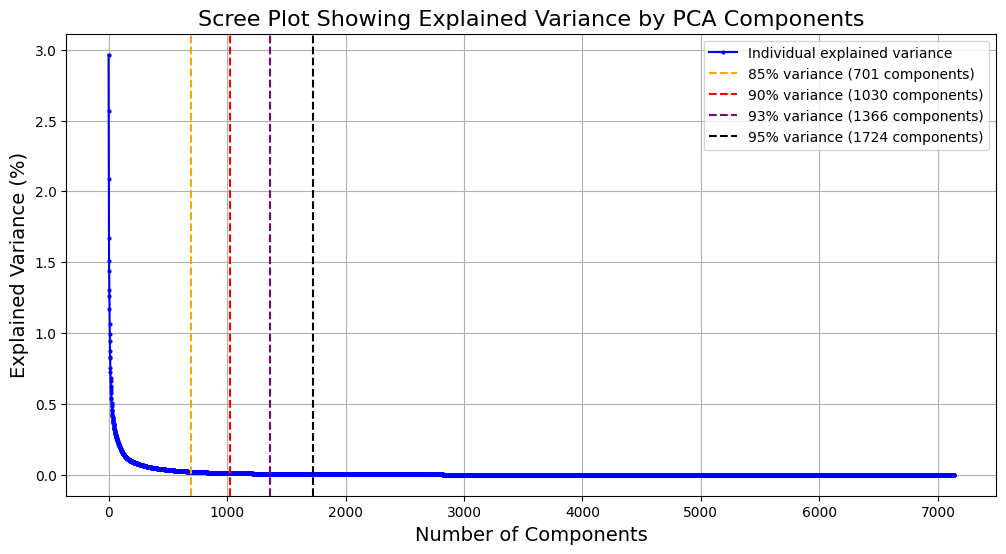

In [44]:
# Data preparation
num_components = len(pca_1.explained_variance_ratio_)
indices = np.arange(num_components)

# Create a scree plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(indices, explained_variance_ratio_percentages, 'o-', markersize=2, color='blue', label='Individual explained variance')

# Highlight the points at 85%, 90%, 93%, and 95%
for percentage, components, color in zip([85, 90, 93, 95], [701, 1030, 1366, 1724], ['orange', 'red', 'purple', 'black']):
    plt.axvline(x=components-1, linestyle='--', color=color, label=f'{percentage}% variance ({components} components)')  # -1 because index starts at 0

# Axis labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance (%)', fontsize=14)
plt.title('Scree Plot Showing Explained Variance by PCA Components', fontsize=16)

# Show the grid and legend
plt.grid(True)
plt.legend(loc='best', fontsize=10)

plt.show()

### **Closer Look at Scree Plot**

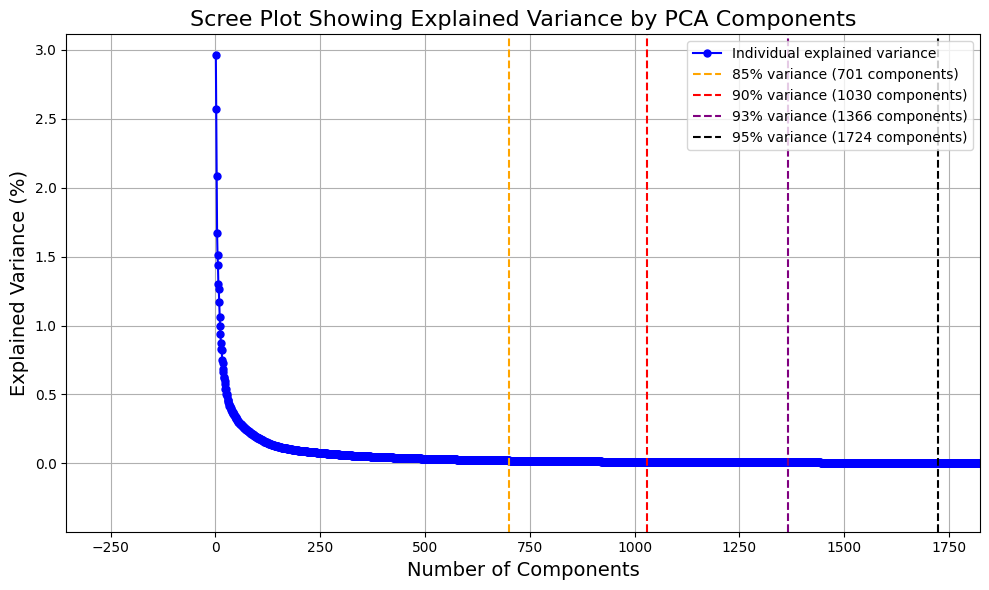

In [53]:
import matplotlib.pyplot as plt
import numpy as np

indices = np.arange(len(explained_variance_ratio_percentages)) + 1  # Component indices (1-based)

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(indices, explained_variance_ratio_percentages, 'o-', markersize=5, color='blue', label='Individual explained variance')

# Highlight the points at 85%, 90%, 93%, and 95% variance explained
for percentage, components, color in zip([85, 90, 93, 95], [701, 1030, 1366, 1724], ['orange', 'red', 'purple', 'black']):
    plt.axvline(x=components, linestyle='--', color=color, label=f'{percentage}% variance ({components} components)')

# Axis labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance (%)', fontsize=14)
plt.title('Scree Plot Showing Explained Variance by PCA Components', fontsize=16)

# Change the x-axis scale to focus on the 'elbow' of the plot
# Set the range to include only the first few components that explain the most variance
elbow_limit = n_components_95 + 100  # Adjust the limit here as needed to focus on the elbow region
plt.xlim(right=elbow_limit)

# Optional: If the y-axis looks squished, adjust the y-axis limit to spread out the data points
plt.ylim(bottom=np.min(explained_variance_ratio_percentages[:elbow_limit])-0.5)

plt.grid(True)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


In [67]:
cumulative_variance_percentages[386].round(2)

75.07

### **Based on the elbow method the n_components that explain the most variance in the data are around 385 whereas According to the cumulative variance around only 75% of data's variance is captured in 386 components compared to 701, 1030, 1366, 1724, components explaining 85%, 90%, 93%, 95% respectively**


### **Deciding on Number of Components:**
### Model Simplicity vs. Completeness: The elbow method leads to a simpler model, which might be easier to interpret and computationally more efficient, but it might miss out on some of the complexities in your data. The cumulative variance method leads to a more complex model that may be able to capture more nuances in the data but at the cost of potential overfitting and higher computational demand. 

>> ## **We decide to proceed with cumulative variance as a more complete approach.**

## **Choosing n_components_93 (95% Variance of the dataset is explained by these 1366 components) and Running PCA again with these components:**

## **Choosing n_components_85 (85% Variance of the dataset is explained by these 701 components) and Running PCA again with these components:**

In [70]:
# For 93% variance explained
pca_93 = PCA(n_components=n_components_93)
X_pca_93 = pca_93.fit_transform(X_centered)

# For 85% variance explained
pca_85 = PCA(n_components=n_components_85)
X_pca_85 = pca_85.fit_transform(X_centered)

## **Principal Component Scores**
## The scores are the representation of your data in the reduced-dimensional space after PCA transformation.
## X_pca_85 and X_pca_93 save the principal component scores

In [75]:

print(X_pca_85.shape)

print(X_pca_93.shape)

(49718, 701)
(49718, 1366)


In [80]:
df_scores_93 = pd.DataFrame(X_pca_93)
df_scores_85 = pd.DataFrame(X_pca_85)

In [81]:
# df_scores_85.to_csv('PCA_85.csv', index=False)
# df_scores_93.to_csv('PCA_93.csv', index=False)


In [74]:
ingredients_df

,id,cuisine,alexia waffle fries,perciatelli,sweet and sour mix,...,bee pollen,low sodium turkey breast,nonfat yogurt plain,oysters,nakano seasoned rice vinegar
0,0,spanish,0,0,0,...,0,0,0,0,0
1,1,mexican,0,0,0,...,0,0,0,0,0
2,2,french,0,0,0,...,0,0,0,0,0
3,3,chinese,0,0,0,...,0,0,0,0,0
4,4,italian,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
49713,49713,southern_us,0,0,0,...,0,0,0,0,0
49714,49714,irish,0,0,0,...,0,0,0,0,0
49715,49715,filipino,0,0,0,...,0,0,0,0,0
49716,49716,indian,0,0,0,...,0,0,0,0,0


### **Loadings represent the correlation between the original variables (in your case, ingredients) and the principal components. They essentially tell us how each principal component is composed in terms of the original features.**

In [76]:
# Accessing the components_ attribute to get the loadings
loadings_93 = pca_93.components_
loadings_85 = pca_85.components_

In [82]:
# Assuming ingredients_df.columns[2:] gives you the ingredient names
ingredient_names = ingredients_df.columns[2:]

# For the 93% variance model
loadings_93_df = pd.DataFrame(pca_93.components_, columns=ingredient_names, index=[f'PC{i+1}' for i in range(pca_93.n_components_)])

# For the 85% variance model
loadings_85_df = pd.DataFrame(pca_85.components_, columns=ingredient_names, index=[f'PC{i+1}' for i in range(pca_85.n_components_)])


In [85]:
loadings_85_df

,alexia waffle fries,perciatelli,sweet and sour mix,corn bread crumbs,black cardamom pods,...,bee pollen,low sodium turkey breast,nonfat yogurt plain,oysters,nakano seasoned rice vinegar
PC1,-0.000028,-0.000022,-0.000165,-0.000003,0.000435,...,-0.000124,-0.000040,0.000388,0.000131,0.000041
PC2,-0.000019,-0.000368,-0.000013,-0.000057,-0.000348,...,-0.000005,-0.000003,-0.000043,0.000664,-0.000009
PC3,-0.000025,-0.000466,-0.000050,-0.000029,0.000731,...,-0.000034,-0.000013,0.000181,-0.000297,0.000026
PC4,-0.000025,0.000085,-0.000070,-0.000043,0.000066,...,-0.000051,-0.000017,-0.000487,0.000321,-0.000054
PC5,-0.000003,-0.000295,-0.000041,-0.000062,-0.000664,...,-0.000025,-0.000011,-0.000244,-0.000712,0.000034
...,...,...,...,...,...,...,...,...,...,...,...
PC697,-0.000101,0.002410,0.000138,0.000414,-0.005146,...,0.000489,0.000042,0.002873,-0.014317,-0.000128
PC698,-0.000054,-0.000100,-0.000648,-0.000321,-0.005343,...,-0.000459,0.000059,-0.003465,0.016957,-0.000164
PC699,-0.000080,-0.001692,0.000211,-0.000115,-0.002871,...,-0.000292,0.000020,-0.000954,-0.027543,0.000177
PC700,0.000035,-0.000543,0.001648,0.000358,-0.000435,...,-0.000135,0.000079,-0.002244,0.007220,-0.000025


In [86]:
loadings_93_df

,alexia waffle fries,perciatelli,sweet and sour mix,corn bread crumbs,black cardamom pods,...,bee pollen,low sodium turkey breast,nonfat yogurt plain,oysters,nakano seasoned rice vinegar
PC1,-0.000028,-0.000022,-0.000165,-0.000003,0.000435,...,-0.000124,-0.000040,0.000388,0.000131,0.000041
PC2,-0.000019,-0.000368,-0.000013,-0.000057,-0.000348,...,-0.000005,-0.000003,-0.000043,0.000664,-0.000009
PC3,-0.000025,-0.000466,-0.000050,-0.000029,0.000731,...,-0.000034,-0.000013,0.000181,-0.000297,0.000026
PC4,-0.000025,0.000085,-0.000070,-0.000043,0.000066,...,-0.000051,-0.000017,-0.000487,0.000321,-0.000054
PC5,-0.000003,-0.000295,-0.000041,-0.000062,-0.000664,...,-0.000025,-0.000011,-0.000244,-0.000712,0.000034
...,...,...,...,...,...,...,...,...,...,...,...
PC1362,-0.000351,-0.001789,-0.000790,-0.001046,-0.002175,...,-0.001785,-0.000021,0.023251,0.005990,-0.000586
PC1363,-0.000069,-0.001572,-0.000927,-0.000234,0.001191,...,-0.007416,0.000131,0.016375,-0.002944,-0.000176
PC1364,-0.000744,-0.000666,0.000334,0.002442,0.007112,...,0.003526,-0.000933,0.029112,0.002968,0.000194
PC1365,-0.000565,0.001710,0.004426,0.000876,-0.009592,...,0.000906,-0.001277,-0.061851,-0.001374,0.000301


In [87]:
# loadings_93_df.to_csv('PCA_93_loadings.csv')
# loadings_85_df.to_csv('PCA_85_loadings.csv')

In [96]:
# To examine the top contributing features for the first principal component
top_features_pc1 = loadings_85_df.loc['PC1'].sort_values(ascending=False)

# Print the top 10 positive contributing features for PC1
print("Top 10 positive contributors to PC1:")
print(top_features_pc1.head(10))

# Print the top 10 negative contributing features for PC1
print("Top 10 negative contributors to PC1:")
print(top_features_pc1.tail(10))

Top 10 positive contributors to PC1:
salt                   0.790007
onions                 0.310928
pepper                 0.244406
olive oil              0.232311
garlic                 0.184379
water                  0.098936
ground black pepper    0.086325
tomatoes               0.082117
ground cumin           0.077139
black pepper           0.070874
Name: PC1, dtype: float64
Top 10 negative contributors to PC1:
corn starch       -0.023097
vanilla extract   -0.024062
green onions      -0.026048
fish sauce        -0.027838
rice vinegar      -0.030874
scallions         -0.031736
sesame oil        -0.041421
soy sauce         -0.069501
kosher salt       -0.101732
sugar             -0.104495
Name: PC1, dtype: float64


# **Now we add Principal Components to our Original/RAW df (non binary representation)**

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49718 entries, 0 to 49717
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           49718 non-null  int64 
 1   cuisine      49718 non-null  object
 2   ingredients  49718 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [91]:

pca_scores_93_df = pd.DataFrame(X_pca_93, columns=[f'PC {i+1}' for i in range(X_pca_93.shape[1])])


final_df_93 = pd.concat([df[['id', 'cuisine', 'ingredients']].reset_index(drop=True), pca_scores_93_df.reset_index(drop=True)], axis=1)


In [92]:
final_df_93

,id,cuisine,ingredients,PC 1,PC 2,...,PC 1362,PC 1363,PC 1364,PC 1365,PC 1366
0,0,spanish,"[mussels, ground black pepper, garlic cloves, ...",-0.177368,-0.649818,...,-0.002909,-0.003784,0.006628,-0.001945,0.004619
1,1,mexican,"[tomatoes, diced red onions, paprika, salt, co...",0.676345,-0.387781,...,-0.020003,-0.010728,-0.000941,-0.002323,0.003223
2,2,french,"[chicken broth, truffles, pimentos, green pepp...",0.283816,0.724659,...,-0.006597,0.000605,-0.005097,0.007900,0.003927
3,3,chinese,"[fresh ginger, sesame oil, frozen peas, cooked...",-0.520112,-0.365672,...,-0.000465,0.001725,0.005162,-0.002117,-0.000621
4,4,italian,"[orange peel, cookies, vanilla ice cream, gran...",-0.605602,-0.029812,...,-0.002762,0.055142,-0.063820,0.008216,-0.054636
...,...,...,...,...,...,...,...,...,...,...,...
49713,49713,southern_us,"[black pepper, large eggs, creole seasoning, r...",-0.515928,0.211335,...,0.005852,0.002660,-0.027158,0.085268,-0.053021
49714,49714,irish,"[chopped fresh thyme, chopped fresh sage, onio...",0.072157,-0.812771,...,0.014317,-0.002825,0.012834,-0.005925,0.005617
49715,49715,filipino,"[crumbled blue cheese, buffalo sauce, avocado,...",-0.595952,-0.152223,...,-0.000220,-0.017881,0.003044,-0.028554,-0.005578
49716,49716,indian,"[water, cinnamon, garlic, cardamom, onions, cl...",0.996633,-0.449822,...,-0.011493,-0.004785,-0.022007,-0.013791,-0.017452


In [93]:
pca_scores_85_df = pd.DataFrame(X_pca_85, columns=[f'PC {i+1}' for i in range(X_pca_85.shape[1])])


final_df_85 = pd.concat([df[['id', 'cuisine', 'ingredients']].reset_index(drop=True), pca_scores_85_df.reset_index(drop=True)], axis=1)

In [94]:
final_df_85

,id,cuisine,ingredients,PC 1,PC 2,...,PC 697,PC 698,PC 699,PC 700,PC 701
0,0,spanish,"[mussels, ground black pepper, garlic cloves, ...",-0.177368,-0.649818,...,-0.009532,-0.008305,0.047556,0.002626,0.067919
1,1,mexican,"[tomatoes, diced red onions, paprika, salt, co...",0.676345,-0.387781,...,0.005328,-0.028132,0.037405,-0.020440,0.012754
2,2,french,"[chicken broth, truffles, pimentos, green pepp...",0.283816,0.724659,...,0.004641,-0.019139,-0.040155,-0.015307,0.003971
3,3,chinese,"[fresh ginger, sesame oil, frozen peas, cooked...",-0.520112,-0.365672,...,-0.001190,0.015797,0.006265,0.003344,-0.001057
4,4,italian,"[orange peel, cookies, vanilla ice cream, gran...",-0.605602,-0.029812,...,-0.131075,0.167701,0.074508,-0.101634,-0.003234
...,...,...,...,...,...,...,...,...,...,...,...
49713,49713,southern_us,"[black pepper, large eggs, creole seasoning, r...",-0.515928,0.211335,...,-0.004174,-0.001669,-0.035926,-0.011982,0.012059
49714,49714,irish,"[chopped fresh thyme, chopped fresh sage, onio...",0.072157,-0.812771,...,0.027316,0.138846,-0.039831,0.081992,0.132200
49715,49715,filipino,"[crumbled blue cheese, buffalo sauce, avocado,...",-0.595952,-0.152223,...,0.009886,-0.008510,0.008197,-0.002649,0.039967
49716,49716,indian,"[water, cinnamon, garlic, cardamom, onions, cl...",0.996633,-0.449822,...,0.006595,-0.026667,-0.055630,-0.089340,0.006316


In [95]:
# final_df_93.to_csv('PCA_93var_1366_components_final.csv', index=False)
# final_df_85.to_csv('PCA_85var_701_components_final.csv', index=False)